### SPAM Classification Problem

This project seeks building a classifier to identify properly if a given text message is spam or not.

#### 1 - Importing libraries

In [194]:
import pandas as pd
import numpy as np

import missingno as mno

import spacy
nlp = spacy.load('en_core_web_sm')

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, roc_curve, precision_recall_curve, confusion_matrix, auc
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense

#### 2 - Importing dataset

The text messages are stores in a *csv* file named **SMSSpamCollection** at which there are two columns:

+ Text
+ Label: ham x spam

In [25]:
data = pd.read_csv('./NLP/SMSSpamCollection.csv', sep='\t', header=None, names=['Label', 'Text'])
data.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


First of all, we need to check if the data is imbalanced.

ham     4825
spam     747
Name: Label, dtype: int64

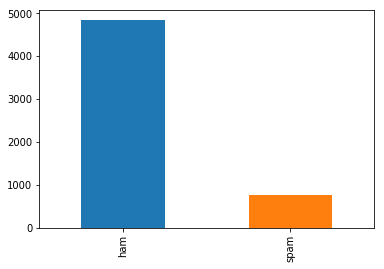

In [26]:
display(data.Label.value_counts())
plt.figure(figsize=(6,4))
data.Label.value_counts().plot(kind='bar');

Since the data is indeed imbalanced, we look for strategies in order to avoid building a model that seeks the maximization of accuracy and always predict that a given message is not spam, since it is the majority class.

In a first moment, we will try to obtain a model using different metrics, such as **recall**, __precision__ or **f1-score**. If we are not succesfull, then oversampling or undersampling strategies can be applied to this problem.

Then, we may also look for missing data or blank text messages.

In [27]:
data.shape

(5572, 2)

In [28]:
data.Label.isnull().value_counts()

False    5572
Name: Label, dtype: int64

In [29]:
data.Text.isnull().value_counts()

False    5572
Name: Text, dtype: int64

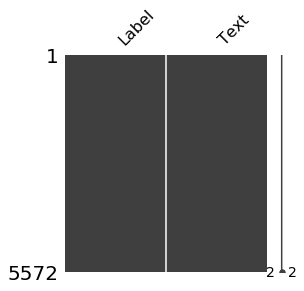

In [37]:
mno.matrix(data, figsize=(4,4));

In [40]:
data[data.Text.str.isspace()==True]

,Label,Text


Then, we can conclude that there is neither missing data nor blank text that could affect negatively the quality of the algorithm.

#### 3 - Extracting Features

Since it is essential to have business knowledge of a given problem in order to solve it applying machine learning algorithms, we must think about appropriate features contained in the text which could lead to a great discrimination of the available data.

For instance, it is expected that spam messages contain a lot of uppercase words and especial caracters and numbers in the text. Hence, it could be a good idea to add these extra features to our model. Moreover, the message length could also be a reasonable feature, once people tend to be straight to the point when texting a message.

In [70]:
data['Length'] = data.Text.str.len()

In [83]:
data['Non-words'] = data['Text'].apply(lambda x: nlp.tokenizer(x.lower()))
data['Non-words'] = data['Non-words'].apply(lambda x: sum(list(map(lambda y: 0 if y.is_alpha else 1, x))))

In [85]:
data.head()

,Label,Text,Length,Non-words
0,ham,"Go until jurong point, crazy.. Available only ...",111,4
1,ham,Ok lar... Joking wif u oni...,29,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,10
3,ham,U dun say so early hor... U c already then say...,49,2
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


#### 3 - Splitting Dataset

In order to train and evaluate the performance of our classifier, we need to test its predictions for labeled previously unseen data - that is, we need to train the algorithm using only a part of our dataset and testing it later with the remaining data points.

In [141]:
y = data.Label.apply(lambda x: 1 if x=='spam' else 0)
X = data.drop(columns=['Label'])

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=99)

Then, in order to process data, we need to convert the text in a bag of words, so the algorithm can learn the data.

In [143]:
tfidf = TfidfVectorizer(max_df = 0.8, min_df=3, ngram_range=(1,3))
X_train_vect = tfidf.fit_transform(X_train['Text'])
X_train_vect

<4179x7475 sparse matrix of type '<class 'numpy.float64'>'
	with 76880 stored elements in Compressed Sparse Row format>

Since Term-Frequency Inverse Document-Frequency procedure can only be applied to text column, we need a method that can add our remaining features to the whole dataset again.

In [144]:
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [145]:
X_train_complete = add_feature(X_train_vect, [X_train['Length'], X_train['Non-words']])
X_train_complete

<4179x7477 sparse matrix of type '<class 'numpy.float64'>'
	with 84944 stored elements in Compressed Sparse Row format>

Then, at least, it is a reasonable measure to standardize the data, in order to allow all features to be on the same scale, so the algorithm does not give different importance to a given feature. However, we pcan build a **pipeline** that takes it into account, so we can prevent data leakage when tuning the hyperparameters of the model.

In [160]:
def evaluation(model, param, X, y):
    
    from sklearn.model_selection import GridSearchCV
    
    clf = Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                      ('classifier', model)])
    
    grid_search = GridSearchCV(clf, param_grid=param, cv=5, n_jobs=-1, scoring='f1', iid=False)
    grid_search.fit(X, y)
    
    return grid_search

def results(grid_model):
    model_params = grid_model.cv_results_['params']
    mean_test = grid_model.cv_results_['mean_test_score']
    std_test = grid_model.cv_results_['std_test_score']
    
    output = pd.DataFrame(model_params).set_index(list(model_params[0].keys()))
    output['MEAN Validação'] = mean_test
    output['STD Validação'] = std_test
    
    print('MELHORES PARÂMETROS:')
    for parametro, valor in grid_model.best_params_.items():
        print('--> ' + parametro + ': ' + str(valor))
    
    display(output)
    
    return

#### 4 - Training the Models

##### 4.1 SVM

In [166]:
model_svm = SVC(random_state=99)
param_svm = {'classifier__C':[1, 3, 10, 30, 100], 'classifier__kernel':['rbf', 'linear'], 'classifier__gamma':[1, 3, 10, 30, 100]}

grid_svm = evaluation(model_svm, param_svm, X_train_complete, y_train)

In [167]:
results(grid_rf)

MELHORES PARÂMETROS:
--> classifier__C: 1
--> classifier__gamma: 1
--> classifier__kernel: linear


MEAN Validação  STD Validação
classifier__C classifier__gamma classifier__kernel                               
1             1                 rbf                       0.406736       0.015533
                                linear                    0.919866       0.013133
              3                 rbf                       0.399586       0.025815
                                linear                    0.919866       0.013133
              10                rbf                       0.376220       0.025921
                                linear                    0.919866       0.013133
              30                rbf                       0.371601       0.021893
                                linear                    0.919866       0.013133
              100               rbf                       0.369197       0.023116
                                linear                    0.919866       0.013133
3             1                 rbf                       0.411237       0.018192
                                linear                    0.919866       0.013133
              3                 rbf                       0.408922       0.019776
                                linear                    0.919866       0.013133
              10                rbf                       0.404434       0.017131
                                linear                    0.919866       0.013133
              30                rbf                       0.371073       0.022078
                                linear                    0.919866       0.013133
              100               rbf                       0.369197       0.023116
                                linear                    0.919866       0.013133
10            1                 rbf                       0.411237       0.018192
                                linear                    0.919866       0.013133
              3                 rbf                       0.408347       0.019984
                                linear                    0.919866       0.013133
              10                rbf                       0.403303       0.017745
                                linear                    0.919866       0.013133
              30                rbf                       0.371073       0.022078
                                linear                    0.919866       0.013133
              100               rbf                       0.369197       0.023116
                                linear                    0.919866       0.013133
30            1                 rbf                       0.411237       0.018192
                                linear                    0.919866       0.013133
              3                 rbf                       0.407220       0.020573
                                linear                    0.919866       0.013133
              10                rbf                       0.403303       0.017745
                                linear                    0.919866       0.013133
              30                rbf                       0.371073       0.022078
                                linear                    0.919866       0.013133
              100               rbf                       0.369197       0.023116
                                linear                    0.919866       0.013133
100           1                 rbf                       0.410094       0.018849
                                linear                    0.919866       0.013133
              3                 rbf                       0.407220       0.020573
                                linear                    0.919866       0.013133
              10                rbf                       0.403303       0.017745
                                linear                    0.919866       0.013133
              30                rbf                       0.371073       0.022078
                                li

##### 4.2 Naive-Bayes Multinomial

In [168]:
model_nb = MultinomialNB()
param_nb = {'classifier__alpha':[0.1, 0.3, 1, 3, 10]}

grid_nb = evaluation(model_nb, param_nb, X_train_complete, y_train)

In [169]:
results(grid_nb)

MELHORES PARÂMETROS:
--> classifier__alpha: 1


,MEAN Validação,STD Validação
classifier__alpha,,
0.1,0.896178,0.018813
0.3,0.895758,0.020680
1.0,0.897557,0.018434
3.0,0.895738,0.018705
10.0,0.897515,0.019401


Training the models with hyperparameters tuned in the whole training set:

In [170]:
model_svm = SVC(C=1, kernel='linear', random_state=99)
svm = Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                      ('classifier', model_svm)])
svm.fit(X_train_complete, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('classifier',
                 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=-1,
                     probability=False, random_state=99, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [171]:
model_nb = MultinomialNB(alpha=1.0)
nb = Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                      ('classifier', model_nb)])
nb.fit(X_train_complete, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

### 5 - Building a Neural Network

In [176]:
nn = Sequential()
nn.add(Dense(128, activation='relu', input_dim=X_train_complete.shape[1]))
nn.add(Dense(64, activation='relu'))
nn.add(Dense(1, activation='sigmoid'))

nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               957184    
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 965,505
Trainable params: 965,505
Non-trainable params: 0
_________________________________________________________________


In [177]:
nn.fit(X_train_complete, y_train, epochs=10)

W0726 21:01:36.802054 19116 deprecation_wrapper.py:119] From C:\Users\gluz9\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/10
4179/4179 [==============================] - 4s 924us/step - loss: 0.3641 - acc: 0.9009
Epoch 2/10
4179/4179 [==============================] - 3s 794us/step - loss: 0.1106 - acc: 0.9672
Epoch 3/10
4179/4179 [==============================] - 3s 802us/step - loss: 0.0759 - acc: 0.9756
Epoch 4/10
4179/4179 [==============================] - 3s 802us/step - loss: 0.0465 - acc: 0.9866
Epoch 5/10
4179/4179 [==============================] - 3s 807us/step - loss: 0.0306 - acc: 0.9921
Epoch 6/10
4179/4179 [==============================] - 3s 780us/step - loss: 0.0314 - acc: 0.9914
Epoch 7/10
4179/4179 [==============================] - 3s 819us/step - loss: 0.0150 - acc: 0.9962
Epoch 8/10
4179/4179 [==============================] - 3s 817us/step - loss: 0.0136 - acc: 0.9966
Epoch 9/10
4179/4179 [==============================] - 3s 793us/step - loss: 0.0128 - acc: 0.9966
Epoch 10/10
4179/4179 [==============================] - 3s 832us/step - loss: 0.0047 - acc: 0.9995


### 6 - Model Evaluation

Now it is time to evaluate each one of the built models in order to select one of them for this particular task. It is necessary to remeber that we need to look for suitable metrics such as recall, f1-score and precision, since the accuracy may be biased due to data imbalance.

In [213]:
def metrics(model, X, y):
    try:
        y_pred = model.predict_classes(X)
    except:
        y_pred = model.predict(X)
    
    print('--> Confusion Matrix:')
    confusion = pd.DataFrame(confusion_matrix(y, y_pred))
    confusion.index = ['True Negative', 'True Positive']
    confusion.columns = ['Predicted Negative', 'Predicted Positive']
    display(confusion)
    
    print('\n--> Classification Report\n')
    print(classification_report(y, y_pred, digits=3))
    
def roc_auc_curve_proba(model, model_name, metric_name, X, y):
    if model_name=='SVM':
        y_pred = model.decision_function(X)
    else:
        try:
            y_pred = model.predict_proba(X)[:,1]
        except:
            y_pred = model.predict(X)

    fpr, tpr, _ = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    lw = 2
    ax1.plot(fpr, tpr, color='darkorange',
             lw=lw, label= model_name + ' (AUC = %0.3f)' % roc_auc)
    ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.0])
    ax1.set_xlabel('False Positive Rate', fontsize=12)
    ax1.set_ylabel('True Positive Rate', fontsize=12)
    ax1.set_title('ROC Curve - ' + metric_name + ' as parameter tuning score')
    ax1.legend(loc="lower right", fontsize=12)
    
    precision, recall, _ = precision_recall_curve(y, y_pred) 
    
    ax2.plot(recall, precision, color='darkorange',
             lw=lw, label= model_name)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.0])
    ax2.set_xlabel('Recall', fontsize=12)
    ax2.set_ylabel('Precision', fontsize=12)
    ax2.set_title('Precision-Recall Curve - ' + metric_name + ' as parameter tuning score')
    ax2.legend(loc="lower left", fontsize=12)
    plt.show()

We should also remember to apply the same transformations to the test dataset.

In [198]:
X_test_vect = tfidf.transform(X_test['Text'])
X_test_vect

<1393x7475 sparse matrix of type '<class 'numpy.float64'>'
	with 23528 stored elements in Compressed Sparse Row format>

In [199]:
X_test_complete = add_feature(X_test_vect, [X_test['Length'], X_test['Non-words']])
X_test_complete

<1393x7477 sparse matrix of type '<class 'numpy.float64'>'
	with 26198 stored elements in Compressed Sparse Row format>

#### 6.1 SVM

In [200]:
metrics(svm, X_test_complete, y_test)

--> Confusion Matrix:


,Predicted Negative,Predicted Positive
True Negative,1199,3
True Positive,19,172



--> Classification Report

              precision    recall  f1-score   support

           0      0.984     0.998     0.991      1202
           1      0.983     0.901     0.940       191

    accuracy                          0.984      1393
   macro avg      0.984     0.949     0.965      1393
weighted avg      0.984     0.984     0.984      1393



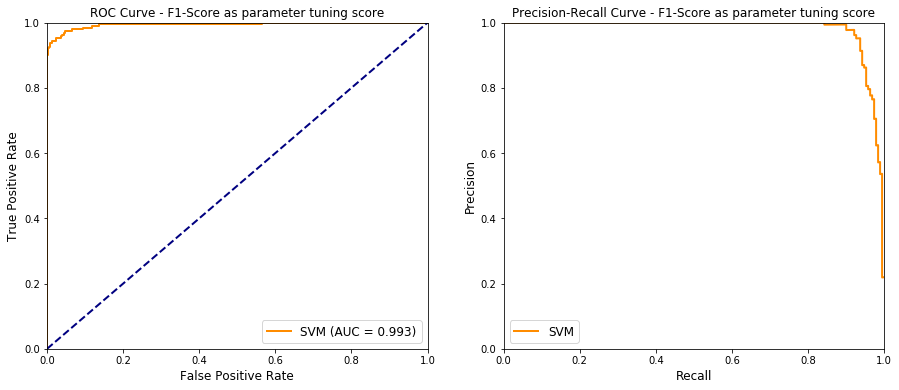

In [201]:
roc_auc_curve_proba(svm, 'SVM', 'F1-Score', X_test_complete, y_test)

#### 6.2 Multinomial NB

In [203]:
metrics(nb, X_test_complete, y_test)

--> Confusion Matrix:


,Predicted Negative,Predicted Positive
True Negative,1182,20
True Positive,13,178



--> Classification Report

              precision    recall  f1-score   support

           0      0.989     0.983     0.986      1202
           1      0.899     0.932     0.915       191

    accuracy                          0.976      1393
   macro avg      0.944     0.958     0.951      1393
weighted avg      0.977     0.976     0.976      1393



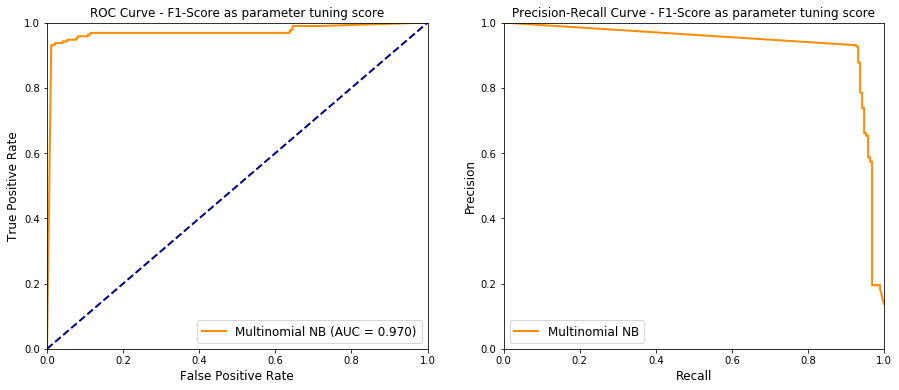

In [206]:
roc_auc_curve_proba(nb, 'Multinomial NB', 'F1-Score', X_test_complete, y_test)

#### 6.3 Neural Network

In [209]:
metrics(nn, X_test_complete, y_test)

--> Confusion Matrix:


,Predicted Negative,Predicted Positive
True Negative,1196,6
True Positive,11,180



--> Classification Report

              precision    recall  f1-score   support

           0      0.991     0.995     0.993      1202
           1      0.968     0.942     0.955       191

    accuracy                          0.988      1393
   macro avg      0.979     0.969     0.974      1393
weighted avg      0.988     0.988     0.988      1393



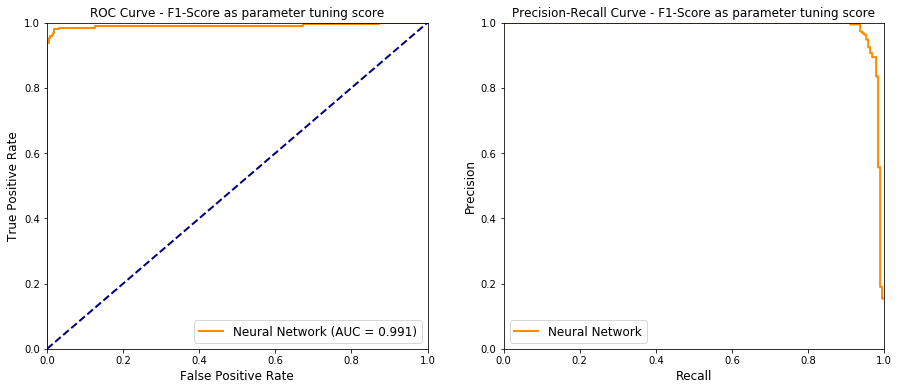

In [214]:
roc_auc_curve_proba(nn, 'Neural Network', 'F1-Score', X_test_complete, y_test)

Comparing ROC curve among all available methods:

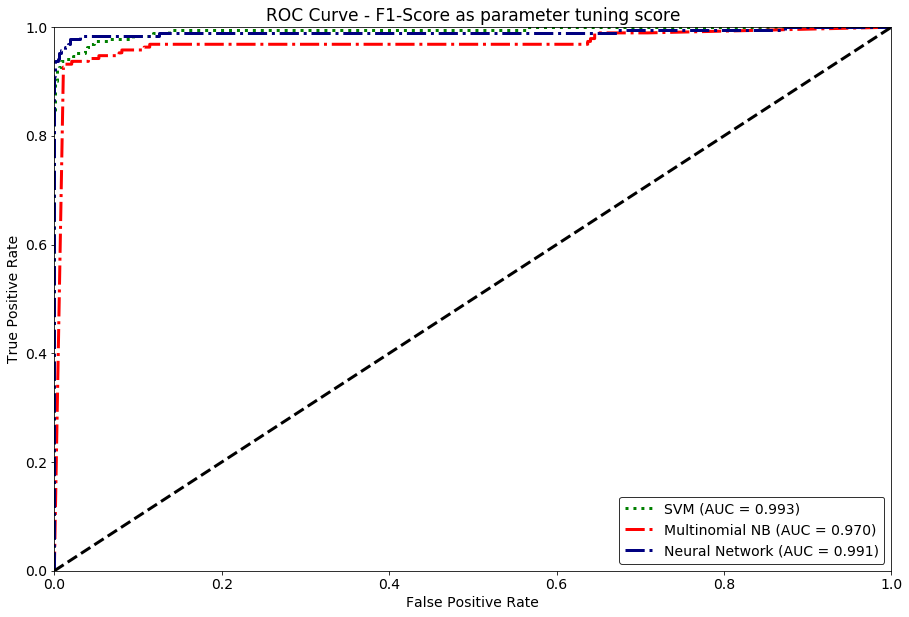

In [217]:
metric_name = 'F1-Score'

fig, ax1 = plt.subplots(1, 1, figsize=(15,10))

model_name = 'SVM'
y_pred = svm.decision_function(X_test_complete)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
lw = 3
ax1.plot(fpr, tpr, color='green', linestyle=':',
         lw=lw, label= model_name + ' (AUC = %0.3f)' % roc_auc)

model_name = 'Multinomial NB'
y_pred = nb.predict_proba(X_test_complete)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
lw = 3
ax1.plot(fpr, tpr, color='red', linestyle='-.',
         lw=lw, label= model_name + ' (AUC = %0.3f)' % roc_auc)

model_name = 'Neural Network'
y_pred = nn.predict(X_test_complete)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
lw = 3
ax1.plot(fpr, tpr, color='navy', linestyle='-.',
         lw=lw, label= model_name + ' (AUC = %0.3f)' % roc_auc)


ax1.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('False Positive Rate', fontsize=14)
ax1.set_ylabel('True Positive Rate', fontsize=14)
ax1.set_title('ROC Curve - ' + metric_name + ' as parameter tuning score', fontsize=17)
leg = ax1.legend(loc="lower right", fontsize=14)
for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
leg.get_frame().set_edgecolor('black')

plt.show()

### 7 - Conclusion

As we can see from data above, we can select the designed **Neural Network** as the best model for the proposed problem, since it presents the best overall performance, especially if we take into account the recall score. In a problem such spam classification, it is more important to avoid false negatives than to correctly predict a non-spam message, once the user does not want to receive any messages filtered as spam.

However, if we think about model simplicity and interpretability, a linear SVM is also a good choice in comparison to a neural network.

Finally, it is possible to realize that our hypothesis about important features in a spam classification problem were suitable, since it has lead us to satisfactory results in the test set.


I hope you have enjoyed this project!!

**Gabriel Fernandes Luz**  
gfluz94@gmail.com